1. add cuisine categories
2. add zipcode -> subboro
3. Drop long/lat/address feature for now
4. Text feature engineering
5. Prepare baseline model

In [93]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import json
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn import datasets, linear_model
from sklearn import metrics
import seaborn as sns 
import math
import threading
from sklearn_pandas import DataFrameMapper
from sklearn.feature_extraction import text
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

%matplotlib inline

### Match zipcode to 55 subboro categories

In [94]:
training = pd.read_csv('01_training.csv')
test = pd.read_csv('01_test.csv')
zipdata = pd.read_csv('zipcode_subboro.csv')[['zcta10','sub_boro']]
zipdata.loc[-1] = [10105,'Chelsea/Clinton/Midtown']
zipdata.index = zipdata.index + 1  # shifting index
zipdata.sort_index(inplace=True)
zipdata.loc[-1] = [10121,'Chelsea/Clinton/Midtown']
zipdata.index = zipdata.index + 1  # shifting index
zipdata.sort_index(inplace=True)
zipdata.loc[-1] = [10281,'Greenwich Village/Financial District']
zipdata.index = zipdata.index + 1  # shifting index
zipdata.sort_index(inplace=True)
zipdata.loc[-1] = [11242,'Brooklyn Heights/Fort Greene']
zipdata.index = zipdata.index + 1  # shifting index
zipdata.sort_index(inplace=True)
zipdata.loc[-1] = [10178,'Chelsea/Clinton/Midtown']
zipdata.index = zipdata.index + 1  # shifting index
zipdata.sort_index(inplace=True)
zipdata.loc[-1] = [11241,'Brooklyn Heights/Fort Greene']
zipdata.index = zipdata.index + 1  # shifting index
zipdata.sort_index(inplace=True)
training = pd.merge(left = training, right = zipdata, how = 'left',left_on='ZIPCODE',right_on='zcta10')
test = pd.merge(left = test, right = zipdata, how = 'left',left_on='ZIPCODE',right_on='zcta10')
training.drop(['zcta10','ADDRESS','DATE','Unnamed: 0'],axis=1,inplace=True)
test.drop(['zcta10','ADDRESS','DATE','Unnamed: 0'],axis=1,inplace=True)

### Set Cuisine Description to 27 cateogries

In [95]:
tmp = pd.read_csv('/Users/jenn/Desktop/matched_yelp_data.csv')
tmp = tmp[['CAMIS','CUISINE DESCRIPTION','ZIPENC']]
tmp.loc[tmp[tmp['CUISINE DESCRIPTION']=='Not Listed/Not Applicable'].index,'CUISINE DESCRIPTION']='Other'
cuisinemap = {'Bakery':'dessert' ,
'CafÃ©/Coffee/Tea': 'cafe',
'Pizza': 'pizza',
'Hamburgers':'fastfood' ,
'American': 'american',
'Ice Cream, Gelato, Yogurt, Ices':'dessert' ,
'Middle Eastern': 'turkish',
'Caribbean': 'caribbean',
'Donuts':'dessert' ,
'Eastern European': 'european',
'Mexican': 'mexican',
'Chicken': 'meat',
'Sandwiches': 'cafe',
'Seafood':'meat' ,
'Latin (Cuban, Dominican, Puerto Rican, South & Central American)': 'latin',
'Delicatessen': 'fastfood',
'Chinese': 'chinese',
'Soups & Sandwiches': 'cafe',
'Indian': 'indian',
'Juice, Smoothies, Fruit Salads': 'drinks',
'Sandwiches/Salads/Mixed Buffet': 'cafe',
'Pizza/Italian': 'pizza',
'Bangladeshi': 'asian',
'Spanish': 'spanish',
'Thai':'thai' ,
'Italian': 'italian',
'Vegetarian': 'vegie',
'Jewish/Kosher': 'other2',
'Creole': 'caribean',
'Armenian': 'european',
'Japanese': 'japanese',
'Soul Food':'american' ,
'Bagels/Pretzels':'dessert' ,
'Korean': 'korean',
'Hotdogs':'fastfood' ,
'Bottled beverages, including water, sodas, juices, etc.': 'drinks',
'Asian': 'asian',
'Tex-Mex':'mexican' ,
'Pakistani': 'asian',
'African':'african' ,
'Fruits/Vegetables': 'vegie',
'Turkish': 'turkish',
'Russian':'european' ,
'Peruvian':'latin' ,
'French':'french' ,
'Afghan': 'asian',
'Other': 'other1',
'Filipino': 'asian',
'Greek':'greek' ,
'Irish': 'european',
'Chinese/Japanese': 'chinese',
'Australian':'european' ,
'Tapas':'spanish' ,
'Chinese/Cuban': 'chinese',
'Steak': 'meat',
'Hawaiian': 'other2',
'Ethiopian': 'african',
'Vietnamese/Cambodian/Malaysia':'asian' ,
'Indonesian': 'asian',
'Salads':'vegie' ,
'Nuts/Confectionary': 'dessert',
'Egyptian':'african' ,
'Polish': 'european',
'Barbecue':'meat' ,
'Cajun': 'caribean',
'German':'european' ,
'Hotdogs/Pretzels':'dessert' ,
'Continental': 'european',
'Pancakes/Waffles':'dessert' ,
'Southwestern':'other2' ,
'English': 'British',
'Brazilian': 'other2',
'Scandinavian': 'european',
'Soups':'other2' ,
'Iranian': 'asian',
'Portuguese': 'other2',
'Californian':'american' ,
'Moroccan':'african' ,
'Chilean':'latin' ,
'Creole/Cajun': 'caribean'}
tmp.replace({'CUISINE DESCRIPTION':cuisinemap},inplace = True)
tmp.replace({'CUISINE DESCRIPTION':{'British':'british','caribean':'caribbean','european':'british'}},inplace = True)
tmp['CUISINE DESCRIPTION'].value_counts()
training = pd.merge(left = training, right = tmp, how = 'left',left_on='CAMIS',right_on='CAMIS')
test = pd.merge(left = test, right = tmp, how = 'left',left_on='CAMIS',right_on='CAMIS')

### Fill in NaN values

In [96]:
def round_to_nearest05(number):
    return round(number*2)/2
mean_prices = training.groupby('CUISINE DESCRIPTION')['yelp_price'].mean().to_dict()
mean_rating = training.groupby('CUISINE DESCRIPTION')['yelp_rating'].mean().to_dict()
for index, row in training.iterrows():
    if math.isnan(row['yelp_price']):
        training.set_value(index,'yelp_price',int(round(mean_prices[row['CUISINE DESCRIPTION']])))
    if math.isnan(row['yelp_rating']):
        training.set_value(index,'yelp_rating',round_to_nearest05(mean_rating[row['CUISINE DESCRIPTION']]))
for index, row in test.iterrows():
    if math.isnan(row['yelp_price']):
        test.set_value(index,'yelp_price',int(round(mean_prices[row['CUISINE DESCRIPTION']])))
    if math.isnan(row['yelp_rating']):
        test.set_value(index,'yelp_rating',round_to_nearest05(mean_rating[row['CUISINE DESCRIPTION']]))        

In [97]:
mean_rodent = training.groupby('sub_boro')['Signs of Rodents'].mean().to_dict()
mean_rodent['Pelham Parkway'] = training['Signs of Rodents'].mean()
for index, row in training.iterrows():
    if math.isnan(row['Signs of Rodents']):
        training.set_value(index,'Signs of Rodents',mean_rodent[row['sub_boro']])
for index, row in test.iterrows():
    if math.isnan(row['Signs of Rodents']):
        test.set_value(index,'Signs of Rodents',mean_rodent[row['sub_boro']])        

In [98]:
training['last_crit_flag'].fillna(0, inplace=True)
training['last_violation_code'].fillna('', inplace=True)
training['last_score'].fillna(training['last_score'].mean(), inplace=True)
training['combined_reviews'].fillna('', inplace=True)
training['Days_since_last'].fillna(10000, inplace=True)

test['last_crit_flag'].fillna(0, inplace=True)
test['last_violation_code'].fillna('', inplace=True)
test['last_score'].fillna(training['last_score'].mean(), inplace=True)
test['combined_reviews'].fillna('', inplace=True)
test['Days_since_last'].fillna(10000, inplace=True)

### Extracting feature from text data

In [99]:
training['is_test'] = 0
test['is_test'] = 1
res = test.append(training)
res.drop(['CAMIS','last_violation_code','ZIPCODE'],axis=1,inplace=True)

#res.drop(['CAMIS','last_violation_code','ZIPCODE','yelp_latitude','yelp_longitude'],axis=1,inplace=True)

res = pd.get_dummies(res,prefix_sep="__",columns=['CUISINE DESCRIPTION','sub_boro'])

In [92]:
res.to_csv('tmp_use.csv')

In [100]:
custom_stops = ("nan", "NaN")
STOP_WORDS = text.ENGLISH_STOP_WORDS.union(custom_stops)
convert_text = DataFrameMapper([('combined_reviews',TfidfVectorizer(stop_words= STOP_WORDS, norm="l2", max_df=0.6, max_features=1000))],default=False)
vect_text_array  = convert_text.fit_transform(res)
vect_text_df = pd.DataFrame(vect_text_array)
text_cols = [x.replace('combined_reviews_','') for x in convert_text.transformed_names_]
vect_text_df.columns = text_cols

res.drop(['combined_reviews','categories'],axis=1,inplace=True)
feature_cols = [feature for feature in res.columns]
combined = res.join(vect_text_df)

In [104]:
from sklearn.preprocessing import MinMaxScaler
combined.iloc[:,:94] = MinMaxScaler().fit_transform(combined.iloc[:,:94])
combined.fillna(0).to_csv('FULL_normalized_data.csv')

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [59]:
len(feature_cols)

95

In [10]:
test = combined[combined['is_test'] == 1]
training = combined[combined['is_test'] == 0]
test.drop(['is_test'],axis=1,inplace=True)
training.drop(['is_test'],axis=1,inplace=True)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [14]:
training.to_csv('01_training_full_features.csv')
test.to_csv('01_test_full_features.csv')

In [11]:
Y_train = training['TARGET']
training.drop(['TARGET'],axis=1,inplace=True)
X_train = training

Y_test = test['TARGET']
test.drop(['TARGET'],axis=1,inplace=True)
X_test = test

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [55]:
def LRValAUC(X_tr, Y_tr, k, cs):
    '''
    Perform k-fold cross validation on logistic regression, varies C and penalty Type (L1 or L2),
    returns a dictionary where key=c,value=[auc-c1, auc-c2, ...auc-ck].
    '''
    aucs = {}
    
    kf = KFold(k)
    for train_index, test_index in kf.split(X_tr):
        X_tr_f = X_tr.loc[train_index]
        X_va_f = X_tr.loc[test_index]
        Y_tr_f = Y_tr.loc[train_index]
        Y_va_f = Y_tr.loc[test_index]
        
        for c in cs:
            for norm in [1,2]:
                lr = linear_model.LogisticRegression(C=c)
                lr.fit(X_tr_f,Y_tr_f)
                met = roc_auc_score(Y_va_f, lr.predict_proba(X_va_f)[:,1])

                if (c, norm) in aucs:
                    aucs[(c,norm)].append(met)
                else:
                    aucs[(c,norm)] = [met]
    
    return lr,aucs

[ 2238  2239  2240 ... 22369 22370 22371]


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

[    0     1     2 ... 22369 22370 22371]


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

[    0     1     2 ... 22369 22370 22371]


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

[    0     1     2 ... 22369 22370 22371]


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

[    0     1     2 ... 22369 22370 22371]


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

[    0     1     2 ... 22369 22370 22371]


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

[    0     1     2 ... 22369 22370 22371]


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

[    0     1     2 ... 22369 22370 22371]


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

[    0     1     2 ... 22369 22370 22371]


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

[    0     1     2 ... 20132 20133 20134]


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

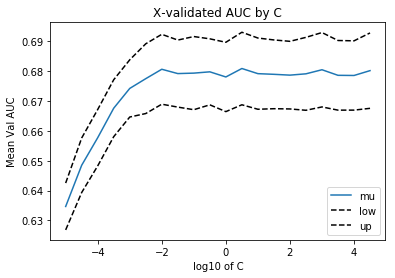

In [56]:
xval_dict = {'e':[], 'mu':[], 'sig':[]}
k = 10
exps = np.arange(-5,5,0.5)
model, auc_cv = LRValAUC(X_train, Y_train, k, [10**i for i in exps])
for i in exps:
    for norm in [1, 2]:
        xval_dict['e'].append(i)
        xval_dict['mu'].append(np.array(auc_cv[(10**i, norm)]).mean())
        xval_dict['sig'].append(np.sqrt(np.array(auc_cv[(10**i, norm)]).var()))

res = pd.DataFrame(xval_dict)
res['low'] = res['mu']-xval_dict['sig']/np.sqrt(k)
res['up'] = res['mu']+xval_dict['sig']/np.sqrt(k)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(res['e'], res['mu'])
plt.plot(res['e'], res['low'], 'k--')
plt.plot(res['e'], res['up'], 'k--')

plt.legend(loc = 4)
ax.set_xlabel('log10 of C')
ax.set_ylabel('Mean Val AUC')
plt.title('X-validated AUC by C')
plt.show()

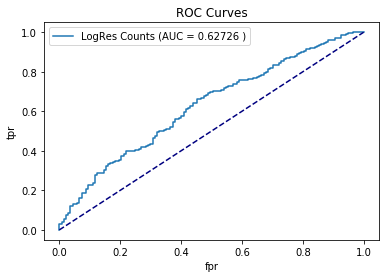

In [57]:
tprs = []
fprs = []
roc_labels = []
fpr, tpr, thresholds = metrics.roc_curve(Y_test, model.predict_proba(X_test)[:,1])
tprs.append(tpr)
fprs.append(fpr)
roc_labels.append("LogRes Counts")
for fpr, tpr, roc_label in zip(fprs, tprs, roc_labels):
    plt.plot(fpr, tpr, label='{} (AUC = {} )'.format(roc_label,'%.5f'% metrics.auc(fpr, tpr)))
plt.plot([0, 1], [0, 1], color='navy',linestyle='--')
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC Curves")
plt.legend()
plt.show() 